In [1]:
%pip install datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 109.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.0 MB/s eta 0:00:00


In [77]:
from datasets import load_dataset

phrases_ds = load_dataset('martingrzzler/concreteness_phrase_ratings')
words_ds = load_dataset('martingrzzler/conreteness_ratings')

  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--conreteness_ratings-8e85e116392013eb/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
phrases_ds['train'].features, words_ds['train'].features

({'Expression': Value(dtype='string', id=None),
  'Mean_C': Value(dtype='float64', id=None),
  'SD_C': Value(dtype='float64', id=None),
  'N_Rate': Value(dtype='float64', id=None),
  'N_Unknown': Value(dtype='int64', id=None),
  '__index_level_0__': Value(dtype='int64', id=None)},
 {'Word': Value(dtype='string', id=None),
  'Bigram': Value(dtype='int64', id=None),
  'Conc.M': Value(dtype='float64', id=None),
  'Conc.SD': Value(dtype='float64', id=None),
  'Unknown': Value(dtype='int64', id=None),
  'Total': Value(dtype='int64', id=None),
  'Percent_known': Value(dtype='float64', id=None),
  'SUBTLEX': Value(dtype='int64', id=None)})

In [80]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

preprocess_df = phrases_ds['train'].to_pandas()
preprocess_df['Mean_C'] = scaler.fit_transform(preprocess_df['Mean_C'].to_numpy().reshape(-1, 1))

phrases_ds['train'] = phrases_ds['train'].from_pandas(preprocess_df)

In [81]:
phrases_ds['train'].to_pandas()['Mean_C'].mean()

0.5324811373349823

<Axes: >

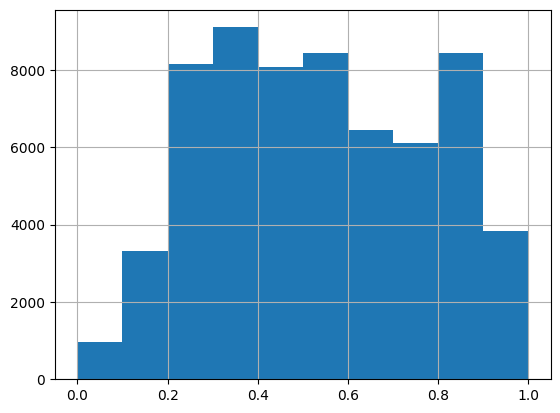

In [82]:
phrases_ds['train'].to_pandas()['Mean_C'].hist()

In [83]:
phrases_ds = phrases_ds.remove_columns(['SD_C', 'N_Rate', 'N_Unknown', '__index_level_0__'])

In [84]:
phrases_ds

DatasetDict({
    train: Dataset({
        features: ['Expression', 'Mean_C'],
        num_rows: 62889
    })
})

In [86]:
words_ds = words_ds.rename_column('Conc.M', 'avg_concreteness')

from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset 

scaler = MinMaxScaler()

processing_ds = words_ds['train'].to_pandas()

processing_ds['avg_concreteness'] = scaler.fit_transform(processing_ds['avg_concreteness'].to_numpy().reshape(-1, 1))

words_ds['train'] = Dataset.from_pandas(processing_ds)


words_ds = words_ds.remove_columns(['Conc.SD', 'Unknown', 'Total', 'SUBTLEX', 'Percent_known', 'Bigram'])

In [87]:
words_ds

DatasetDict({
    train: Dataset({
        features: ['Word', 'avg_concreteness'],
        num_rows: 39954
    })
})

In [9]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [93]:
words_ds = words_ds.rename_column('Word', 'text')
words_ds = words_ds.rename_column('avg_concreteness', 'labels')

phrases_ds = phrases_ds.rename_column('Expression', 'text')
phrases_ds = phrases_ds.rename_column('Mean_C', 'labels')

In [97]:
#remove nan values
words_ds = words_ds['train'].filter(lambda x: type(x['text']) == str)

Filter:   0%|          | 0/39954 [00:00<?, ? examples/s]

In [98]:
words_ds, phrases_ds

(Dataset({
     features: ['text', 'labels'],
     num_rows: 39953
 }),
 DatasetDict({
     train: Dataset({
         features: ['text', 'labels'],
         num_rows: 62889
     })
 }))

In [100]:
# merge the two datasets
from datasets import concatenate_datasets

ds = concatenate_datasets([words_ds, phrases_ds['train']])


In [65]:

exprs = phrases_ds['train'].to_pandas()['Expression'].to_list()
max_len = 0

for expr in exprs:
    length = len(tokenizer(expr, truncation=True, padding=True)['input_ids'])
    if length > max_len:
        max_len = length

print(max_len)

39


In [107]:
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=50)

In [108]:
tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/102842 [00:00<?, ? examples/s]

In [110]:
tokenize(tokenized_ds[0])

{'input_ids': [101, 1037, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [111]:
tokenized_ds = tokenized_ds.train_test_split(test_size=0.1, shuffle=True)

In [112]:
tokenized_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [125]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_ds['train'], batch_size=8)
test_loader = DataLoader(tokenized_ds['test'], batch_size=8)

In [126]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [127]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [128]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=2e-5)

In [129]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = len(train_loader) * num_epochs

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
     

In [132]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
losses = []

model.train()
for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs.loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/34710 [00:00<?, ?it/s]

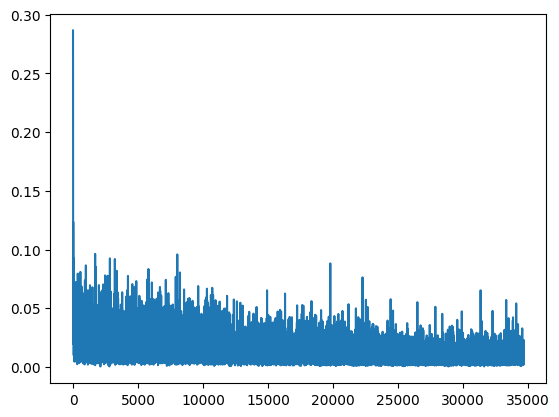

In [133]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [134]:
from scipy.stats import pearsonr

model.eval()

predictions = []
targets = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions.extend(logits.squeeze(-1).tolist())
    targets.extend(batch["labels"].tolist())





corr_corf, p_value = pearsonr(predictions, targets)

print(f"Pearson Correlation Coefficient: {corr_corf:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.8837
P-value: 0.0000


In [136]:
def predict_phrase(phrase):
    tokenized_phrase = tokenizer(phrase, return_tensors="pt", padding='max_length', truncation=True, max_length=50).to(device)
    with torch.no_grad():
        outputs = model(**tokenized_phrase)
    logits = outputs.logits
    return logits.squeeze(-1).tolist()[0]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [135]:
model.push_to_hub('martingrzzler/distilbert-phrase-word-concreteness', create_pr=1)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/martingrzzler/distilbert-phrase-word-concreteness/commit/ddf98d2fe1c8618bba3afcaabeaaad56d026ff13', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='ddf98d2fe1c8618bba3afcaabeaaad56d026ff13', pr_url='https://huggingface.co/martingrzzler/distilbert-phrase-word-concreteness/discussions/1', pr_revision='refs/pr/1', pr_num=1)